<img src="assets/spam.png" style="display:block; margin:auto" width=350>

<div align="center"> <h1 align="center"> Project: Building a Spam Filter with Naive Bayes </h1> </div>

In an age where communication via digital messages is omnipresent, the challenge of filtering out spam from legitimate messages has become increasingly crucial. In response to this challenge, the attempt of this data science project is to develop a robust spam filter for digital messages making use of the `multinomial Naive Bayes Algorithm`.

#### Goal 

The primary objective of this project is to construct a spam filter capable of classifying new messages with an accuracy exceeding 80%. Using a dataset including 5,572 messages, labeled as spam or ham (non-spam) by humans, the project includes data science topics such as exploration, preprocessing, model training, and evaluation.

#### Data

The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). 

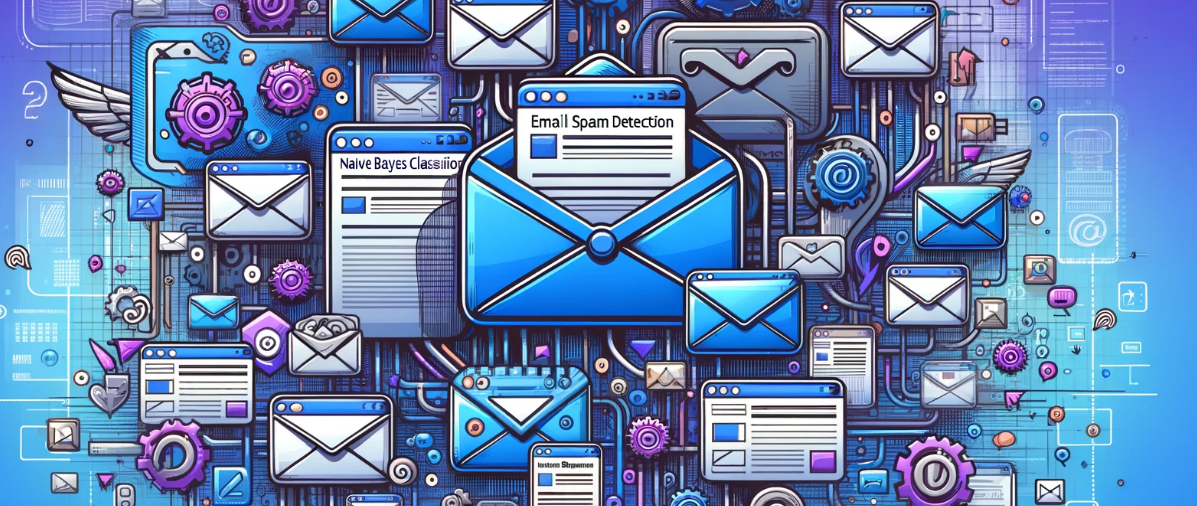

In [1]:
# Import relevant packages

import pandas as pd

In [2]:
# Read the dataset, set separator to tab, no header, label columns
data = pd.read_csv('SMSSpamCollection.csv', sep='\t', header=None, names=['Label', 'SMS'])

In [3]:
# Print first rows of dataset
data.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Check dataset information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
# Count the values for Label column, calculate percentages
data['Label'].value_counts(normalize=True) * 100

Label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64

The dataset contains 5571 rows and two columns. One column describes the type of message: 'Spam' or 'Ham'. The 'SMS' column contains the original message. Using the `value_counts()` command we can calculate the proportion of 'Spam' or 'Ham' messages: approximately 87% are 'Ham' messages, 13% are 'Spam' messages.

Now that we've become a bit familiar with the dataset, we can move on to building the spam filter.

However, before creating it, it's very helpful to first think of a way of testing how well it works. When creating software (a spam filter is software), a good rule of thumb is that designing the test comes before creating the software. If we write the software first, then it's tempting to come up with a biased test just to make sure the software passes it.

Once our spam filter is done, we'll need to test how good it is with classifying new messages. To test the spam filter, we're first going to split our dataset into two categories:

A training set, which we'll use to "train" the computer how to classify messages.
A test set, which we'll use to test how good the spam filter is with classifying new messages.
We're going to keep 80% of our dataset for training, and 20% for testing (we want to train the algorithm on as much data as possible, but we also want to have enough test data). The dataset has 5,572 messages, which means that:

The training set will have 4,458 messages (about 80% of the dataset).
The test set will have 1,114 messages (about 20% of the dataset).
To better understand the purpose of putting a test set aside, let's begin by observing that all 1,114 messages in our test set are already classified by a human. When the spam filter is ready, we're going to treat these messages as new and have the filter classify them. Once we have the results, we'll be able to compare the algorithm classification with that done by a human, and this way we'll see how good the spam filter really is.

For this project, our goal is to create a spam filter that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

#### Training and Test Data

We're now going to split our dataset into a training and a test set, where the training set accounts for 80% of the data, and the test set for the remaining 20%.


In [6]:
# Randomize the data with sample
data_rn = data.sample(frac=1, random_state=1)

# Calculate index for split
training_test_index = round(len(data_rn) * 0.8)

# Split the data in training and test data
training_data = data_rn[:training_test_index].reset_index(drop=True)
test_data = data_rn[training_test_index:].reset_index(drop=True)

print(training_data.shape)
print(test_data.shape)

(4458, 2)
(1114, 2)


In [7]:
# Check 80% data information
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4458 entries, 0 to 4457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4458 non-null   object
 1   SMS     4458 non-null   object
dtypes: object(2)
memory usage: 69.8+ KB


In [8]:
# Check 20% data information
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114 entries, 0 to 1113
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   1114 non-null   object
 1   SMS     1114 non-null   object
dtypes: object(2)
memory usage: 17.5+ KB


In [9]:
# Count values for label for 80% training data
training_data['Label'].value_counts(normalize=True) * 100

Label
ham     86.54105
spam    13.45895
Name: proportion, dtype: float64

In [10]:
# Count values for label for 20% test data
test_data['Label'].value_counts(normalize=True) * 100

Label
ham     86.804309
spam    13.195691
Name: proportion, dtype: float64

After randomizing the dataset with `sample()`, we used a 80/20 split in training and test data. Both of the new datasets do have quite similar values for 'Ham' and 'Spam', compared to the original dataset.

Next, we'll first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need. We'll begin with the data cleaning process by removing the punctuation and bringing all the words to lower case.

#### Data Cleaning

To calculate all the probabilities required by the algorithm, we'll first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need.t:

In [11]:
# replace all punctuations with whitepace
training_data['SMS'] = training_data['SMS'].str.replace('\W', ' ', regex=True).str.lower()
test_data['SMS'] = test_data['SMS'].str.replace('\W', ' ', regex=True).str.lower()

In [12]:
training_data.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


#### Creating the Vocabulary

Let's now move to creating the vocabulary, which in this context means a list with all the unique words in our training set.


In [13]:
vocabulary = []
training_data['SMS'] = training_data['SMS'].str.split()

for message in training_data['SMS']:
    for word in message:
        vocabulary.append(word)
        
vocabulary = list(set(vocabulary))

In [14]:
len(vocabulary)

7783

There are 7,783 unique words in all the messages of our training set.

#### The Training Data

We're now going to use the vocabulary we just created to make the data transformation we want.


In [15]:
word_counts_per_sms = {unique_word: [0] * len(training_data['SMS']) for unique_word in vocabulary}

for index, message in enumerate(training_data['SMS']):
        for word in message:
            word_counts_per_sms[word][index] += 1

In [16]:
word_count_df = pd.DataFrame(word_counts_per_sms)
word_count_df.head()

,keluviri,ela,08718726978,m,mjzgroup,beforehand,urination,happend,address,a21,...,cardiff,him,tming,wc1n,snowball,downloads,manual,rental,savings,watching
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
training_data_clean = pd.concat([training_data, word_count_df], axis=1)
training_data_clean.head()

,Label,SMS,keluviri,ela,08718726978,m,mjzgroup,beforehand,urination,happend,...,cardiff,him,tming,wc1n,snowball,downloads,manual,rental,savings,watching
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Calculating Constants First

We're now done with cleaning the training data, and we can begin creating the spam filter.

\begin{equation}
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam)
\end{equation}

\begin{equation}
P(Ham | w_1,w_2, ..., w_n) \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
\end{equation}

Also, to calculate P(wi|Spam) and P(wi|Ham) inside the formulas above, we'll need to use these equations:

\begin{equation}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
\end{equation}

\begin{equation}
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation}

Some of the terms in the four equations above will have the same value for every new message. We can calculate the value of these terms once and avoid doing the computations again when a new messages comes in. Below, we'll use our training set to calculate:

- P(Spam) and P(Ham)
- NSpam, NHam, NVocabulary
  
We'll also use Laplace smoothing and set alpha = 1.

In [18]:
# Isolating spam and ham messages 
ham_messages = training_data_clean[training_data_clean['Label'] == 'ham']
spam_messages = training_data_clean[training_data_clean['Label'] == 'spam']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(training_data_clean)
p_ham = len(ham_messages) / len(training_data_clean)

# N_Spam
n_spam = spam_messages['SMS'].apply(len).sum()

# N_Ham
n_ham = ham_messages['SMS'].apply(len).sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

In [19]:
print(f'The value for p_spam is: ' + str(p_spam))
print(f'The value for p_ham is: ' + str(p_ham))
print(f'The value for n_spam is: ' + str(n_spam))
print(f'The value for n_Ham is: ' + str(n_ham))
print(f'The value for n_vocabulary is: ' + str(n_vocabulary))

The value for p_spam is: 0.13458950201884254
The value for p_ham is: 0.8654104979811574
The value for n_spam is: 15190
The value for n_Ham is: 57237
The value for n_vocabulary is: 7783


#### Calculating Parameters

Now that we have the constant terms calculated above, we can move on with calculating the parameters. Each parameter will thus be a conditional probability value associated with each word in the vocabulary.

The parameters are calculated using the formulas:

\begin{equation}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
\end{equation}

\begin{equation}
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation}

In [20]:
# Initiate parameters
parameters_spam = {unique_word: 0 for unique_word in vocabulary}
parameters_ham = {unique_word: 0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum()   # Spam_messages already defined in a cell above
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha * n_vocabulary) # Use given formular
    parameters_spam[word] = p_word_given_spam # Update value of dictionary created before
    
    n_word_given_ham = ham_messages[word].sum()   # Ham_messages already defined in a cell above
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha * n_vocabulary) # Use given formular
    parameters_ham[word] = p_word_given_ham # Update value of dictionary created before

In [21]:
# Check ham parameters
parameters_ham

{'keluviri': 3.075976622577668e-05,
 'ela': 4.6139649338665025e-05,
 '08718726978': 1.537988311288834e-05,
 'm': 0.005121501076591818,
 'mjzgroup': 1.537988311288834e-05,
 'beforehand': 3.075976622577668e-05,
 'urination': 3.075976622577668e-05,
 'happend': 6.151953245155337e-05,
 'address': 0.0001845585973546601,
 'a21': 1.537988311288834e-05,
 'woodland': 3.075976622577668e-05,
 'red': 0.00015379883112888343,
 'may': 0.0005229160258382037,
 'served': 3.075976622577668e-05,
 'drinkin': 4.6139649338665025e-05,
 'skint': 3.075976622577668e-05,
 'txt': 0.0001845585973546601,
 'onto': 1.537988311288834e-05,
 'grams': 3.075976622577668e-05,
 '25': 3.075976622577668e-05,
 'chatlines': 1.537988311288834e-05,
 '3days': 3.075976622577668e-05,
 '7ish': 4.6139649338665025e-05,
 'thankyou': 3.075976622577668e-05,
 'although': 4.6139649338665025e-05,
 'killed': 3.075976622577668e-05,
 'frauds': 4.6139649338665025e-05,
 'dracula': 1.537988311288834e-05,
 'deus': 4.6139649338665025e-05,
 'rael': 3.0

In [22]:
# Check spam parameters
parameters_spam

{'keluviri': 4.3529360553693465e-05,
 'ela': 4.3529360553693465e-05,
 '08718726978': 8.705872110738693e-05,
 'm': 0.0007399991294127889,
 'mjzgroup': 8.705872110738693e-05,
 'beforehand': 4.3529360553693465e-05,
 'urination': 4.3529360553693465e-05,
 'happend': 4.3529360553693465e-05,
 'address': 0.00017411744221477386,
 'a21': 8.705872110738693e-05,
 'woodland': 4.3529360553693465e-05,
 'red': 0.00017411744221477386,
 'may': 0.0002611761633221608,
 'served': 4.3529360553693465e-05,
 'drinkin': 4.3529360553693465e-05,
 'skint': 4.3529360553693465e-05,
 'txt': 0.0057458755930875375,
 'onto': 0.00030470552387585427,
 'grams': 4.3529360553693465e-05,
 '25': 0.00017411744221477386,
 'chatlines': 8.705872110738693e-05,
 '3days': 4.3529360553693465e-05,
 '7ish': 4.3529360553693465e-05,
 'thankyou': 4.3529360553693465e-05,
 'although': 4.3529360553693465e-05,
 'killed': 4.3529360553693465e-05,
 'frauds': 4.3529360553693465e-05,
 'dracula': 0.0001305880816610804,
 'deus': 4.3529360553693465e-0

#### Classifying A New Message

Now that we have all our parameters calculated, we can start creating the spam filter. The spam filter can be understood as a function that:

1. Takes in as input a new message (w1, w2, ..., wn).
2. Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn).
3. Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:
4. If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
5. If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
6. If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.

In [23]:
import re

def classify(message): # String
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
            
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)
    
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [24]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


In [25]:
classify('Thank you, Tom, i really liked your present')

P(Spam|message): 3.841541019719408e-29
P(Ham|message): 7.166454893635636e-25
Label: Ham


#### Measuring the Accuracy

The two results above look promising, but let's see how well the filter does on our test set, which has 1,114 messages.

We'll start by writing a function that returns classification labels instead of printing them.

In [26]:
def classify_test_data(message): # String
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
    
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

Now that we have a function that returns labels instead of printing them, we can use it to create a new column in our test set.

In [27]:
test_data['prediction'] = test_data['SMS'].apply(classify_test_data)
test_data.head()

,Label,SMS,prediction
0,ham,later i guess i needa do mcat study too,ham
1,ham,but i haf enuff space got like 4 mb,ham
2,spam,had your mobile 10 mths update to latest oran...,spam
3,ham,all sounds good fingers makes it difficult ...,ham
4,ham,all done all handed in don t know if mega sh...,ham


In [28]:
correct = 0
total = test_data.shape[0]

for index, message in test_data.iterrows():
    if message['Label'] == message['prediction']:
        correct += 1

accuracy = round(correct / total * 100, 2)
print(accuracy)

98.74


The accuracy is 98.74%, which is really good. Our spam filter looked at 1,114 messages that it hasn't seen in training, and classified 1,100 correctly.

#### Conclusion

In this data science project we successfully developed a spam filter for SMS messages using the `multinomial Naive Bayes Algorithm`. The primary objective was to achieve an accuracy greater than 80%, and the achieved accuracy on the test set was an impressive 98.74%. 

Throughout the project, we followed a systematic approach, starting from data exploration, where we analyzed the dataset's structure and distribution of 'Spam' and 'Ham' messages. We then preprocessed the data, including removing punctuation, converting text to lowercase, and creating a vocabulary of unique words.

Using the training data, we calculated the necessary constants and parameters for the `Naive Bayes Algorithm`, including probabilities of 'Spam' and 'Ham' messages, as well as conditional probabilities of words given the message's label. These calculations enabled us to classify new messages accurately.

The spam filter demonstrated robust performance on unseen data, correctly classifying 1,100 out of 1,114 messages in the test data. This high accuracy indicates the effectiveness of the developed model in distinguishing between 'Spam' and 'Ham' messages.

Overall, this project exemplifies the power of data science in addressing real-world challenges and underscores the importance of robust methodologies in developing effective solutions.